In [1]:
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams['font.size'] = 14

import keras
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten #, Reshape
from keras.layers import Conv1D, MaxPooling1D, AveragePooling1D

%run plot.py

### Read data

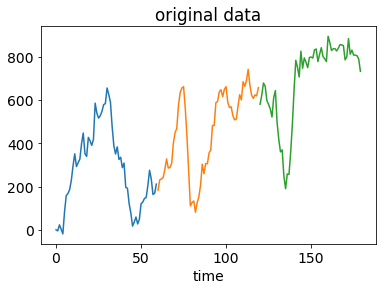

data:  10000


In [2]:
str0 = 'ts_L60_Z12_A500_DX50_bias5_N10000.dat'
fnamex='DATA/x_'+str0
fnamey='DATA/y_'+str0

x = np.loadtxt(fnamex, delimiter=" ",dtype=float)
N,L = len(x), len(x[0])

Show_data(x,L,"original data")

categ = np.loadtxt(fnamey, dtype=int)
n_class = 3    # y.argmax() - y.argmin() +1
print('data: ',N)

y = np.zeros((N,n_class))
for i in range(N):
    y[i][categ[i]] = 1.

### Rescale data, split train/val.

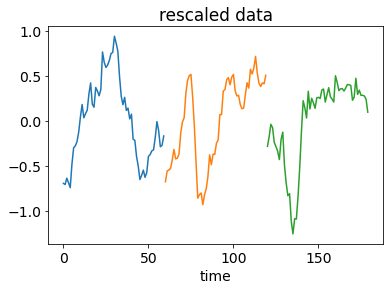

N_train= 8000   N_val= 2000   L= 60   n_class= 3


In [3]:
#
#  FIRST PASSAGE:  DO NOT DO THIS --> FAILURE 
#
#remove average value of each sample from its values
xm = x.mean(axis=1)
for i in range(N):
    x[i] = x[i]-xm[i]

#
#  SECOND PASSAGE:  DO NOT DO THIS --> ALSO FAILURE 
#
#rescale (crude version, variance should be used)
x = x/400
    
Show_data(x,L,"rescaled data")

perc_train=0.8
N_train = int(perc_train*N)
x_train = x[:N_train]
y_train = y[:N_train]
x_val = x[N_train:]
y_val = y[N_train:]
N_val = len(x_val)
print('N_train=',N_train,'  N_val=',N_val,'  L=',L,'  n_class=',n_class)

#x_train=x_train.astype("float32")
#y_train=y_train.astype("float32")
#x_val=x_val.astype("float32")
#y_val=y_val.astype("float32")

# Keras wants an additional dimension with a 1 at the end
x_train = x_train.reshape(x_train.shape[0], L, 1)
x_val =  x_val.reshape(x_val.shape[0], L, 1)
input_shape = (L, 1)

## Convolutional NN

In [2]:
def CNN(lambdaa, input_shape, n_class,TYPE):
    
    if TYPE==1:
        reg = tf.keras.regularizers.l1(lambdaa)
        
    elif TYPE==2:
        reg = tf.keras.regularizers.l2(lambdaa)
      
    elif TYPE==3:
        reg = tf.keras.regularizers.l1_l2(lambdaa)

    ini = tf.keras.initializers.RandomNormal(mean=0.0, stddev=0.05, 
                                        seed=None)
    NF = 5
    
    model = Sequential()
    model.add(Conv1D(filters=NF, kernel_size=11, 
                     kernel_initializer=ini, 
                     kernel_regularizer=reg,
                     activation='relu', 
                     input_shape=input_shape))
    #model.add(MaxPooling1D(3))
    model.add(AveragePooling1D(5))
    model.add(Conv1D(filters=5, kernel_size=7, 
                     activation='relu'))
    model.add(Flatten())
    model.add(Dense(12, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(n_class, activation='softmax')) # softmax !
    opt = tf.keras.optimizers.Adam()

    # compile the model
    # categorical_crossentropy, 3 output nodes
    model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=opt,metrics=['accuracy'])
    
    return model

In [3]:
def Show_weights(model,l=0,label="model"):
    c=['r','y','c','b','m']
    m=['o','s','D','<','>']
    ms=10
    
    w = model.layers[l].get_weights()[0]
    wT=w.T
    M=len(wT)
    b = model.layers[l].get_weights()[1]
    
    fig,AX=plt.subplots(1,2,figsize=(12,4.4))
    ax=AX[0]
    ax.axhline(0, c="k")
    ax.plot((0,))
    for i in range(M):
        ax.plot(wT[i][0],"-",c=c[i],marker=m[i],label=str(i),markersize=ms)
    ax.set_title(label+': filters of layer '+str(l))
    ax.set_xlabel('index')
    ax=AX[1]
    ax.axhline(0, c="k")
    for i in range(M):
        ax.plot((i),(b[i]),c=c[i],marker=m[i],label="filter "+str(i),markersize=ms)
    ax.set_title(label+': bias of layer '+str(l))
    ax.set_xlabel('filter nr')
    ax.set_xticks(np.arange(5))
    ax.legend()
    plt.show()
    

In [4]:
def Show_history(fit):
    fig,AX=plt.subplots(1,2,figsize=(12,5.))
    ax=AX[0]
    ax.plot(fit.history['accuracy'],"b",label="train")
    ax.plot(fit.history['val_accuracy'],"r--",label="valid.")
    ax.plot((0,EPOCHS),(1/3,1/3),":",c="gray",label="random choice")
    ax.set_xlabel('epoch')
    ax.set_ylabel("Accuracy")
    ax.set_ylim([0, 1])
    ax.legend()
    ax=AX[1]
    ax.plot(fit.history['loss'],"b",label="train")
    ax.plot(fit.history['val_loss'],"r--",label="valid.")
    ax.set_xlabel('epoch')
    ax.set_ylabel("Loss")
    ax.set_ylim([0, 1.05*np.max(fit.history['loss'])])
    ax.legend()
    plt.show()


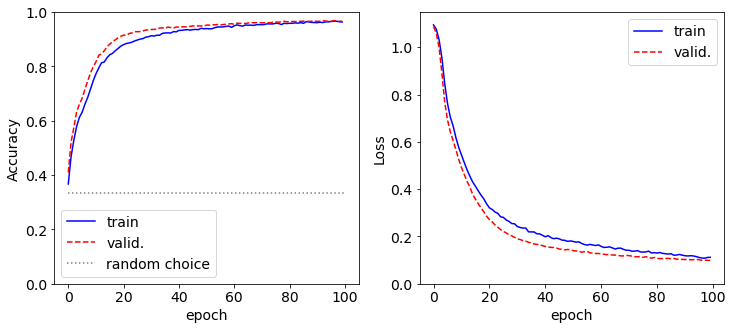

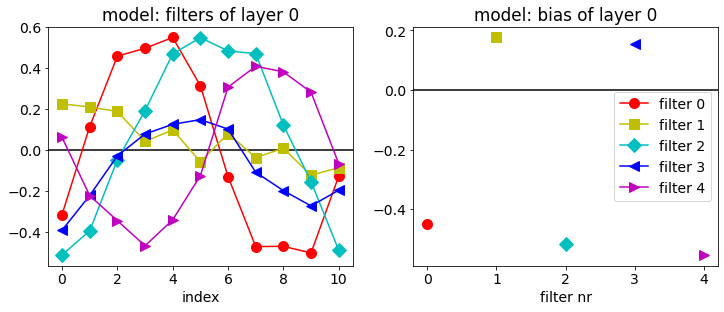

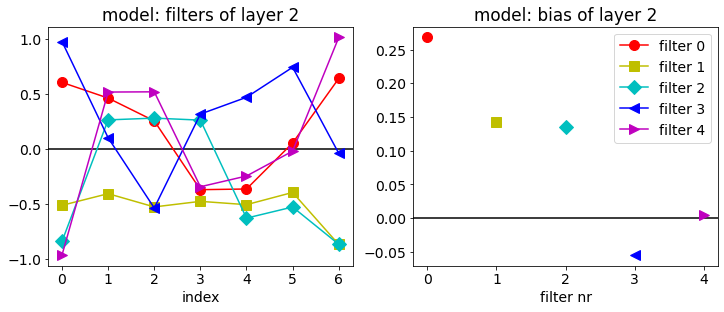

done for: 0


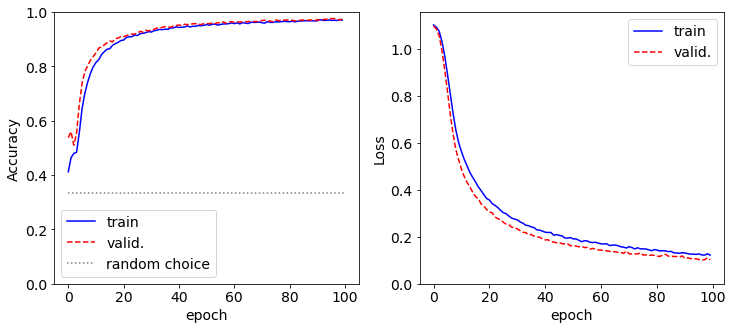

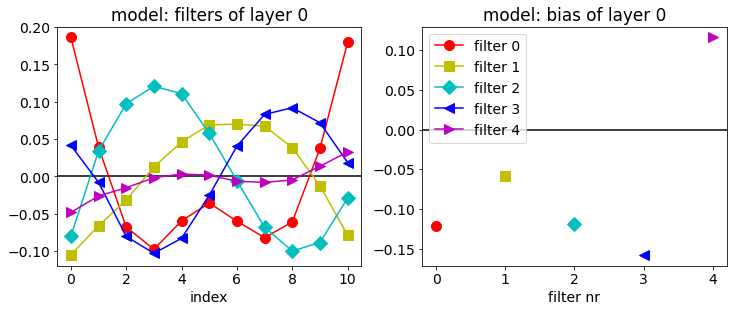

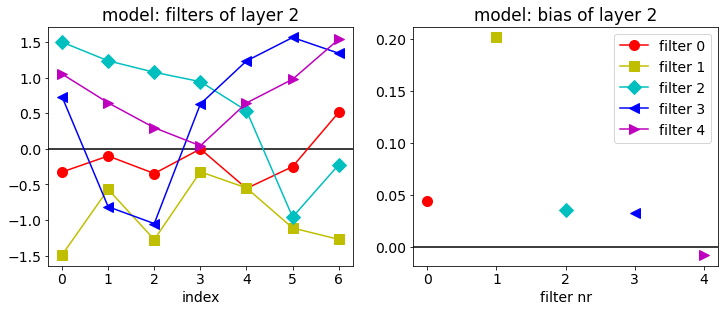

done for: 0.1


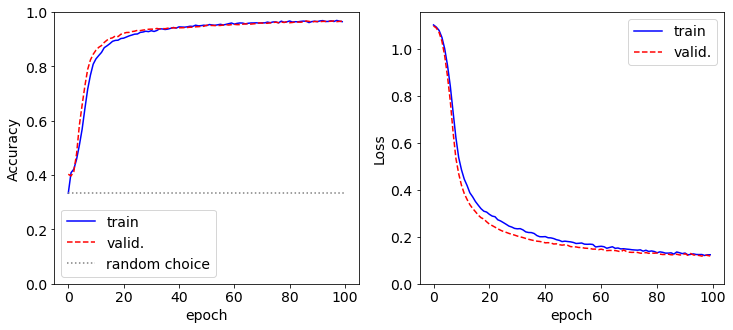

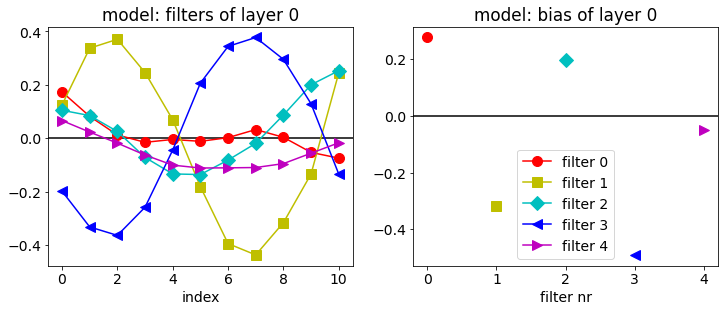

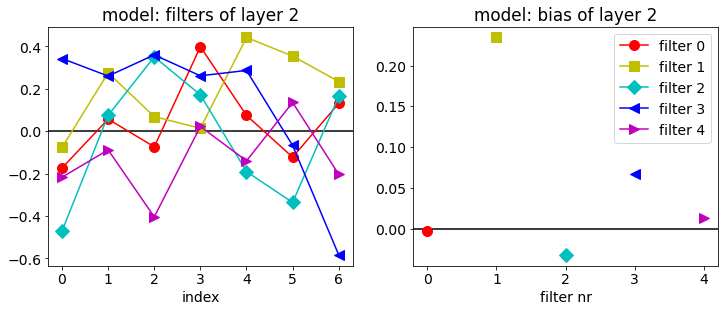

done for: 0.01


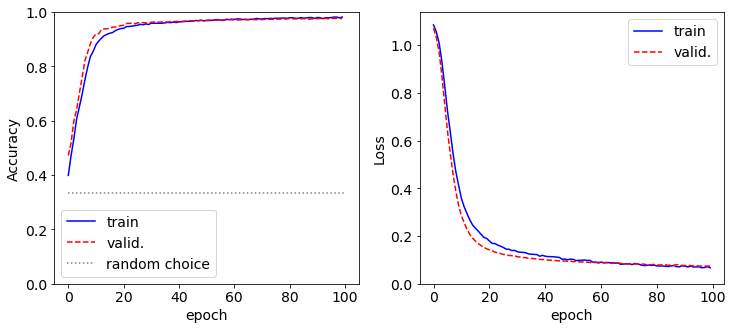

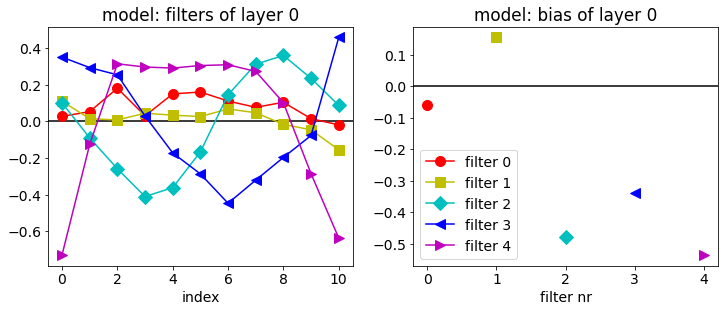

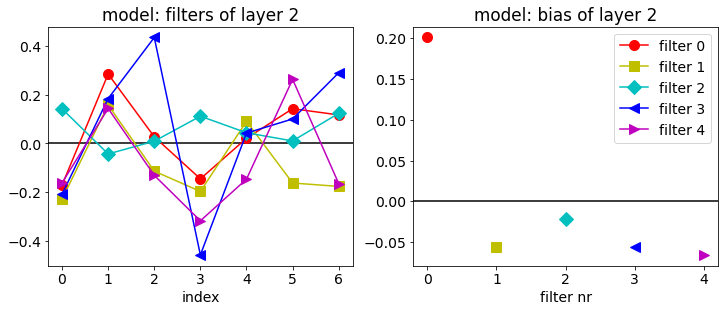

done for: 0.001


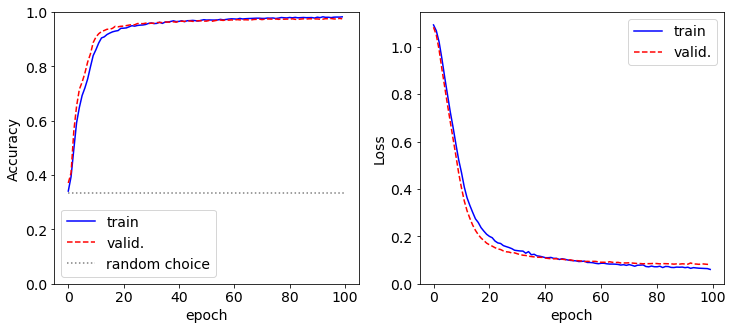

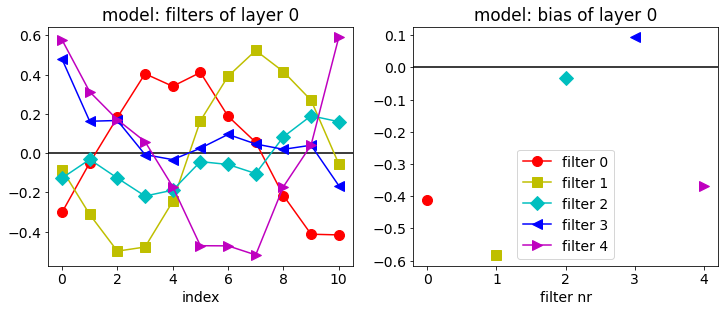

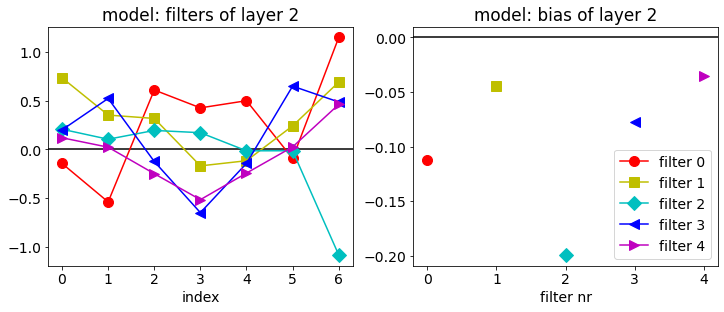

done for: 0.0001


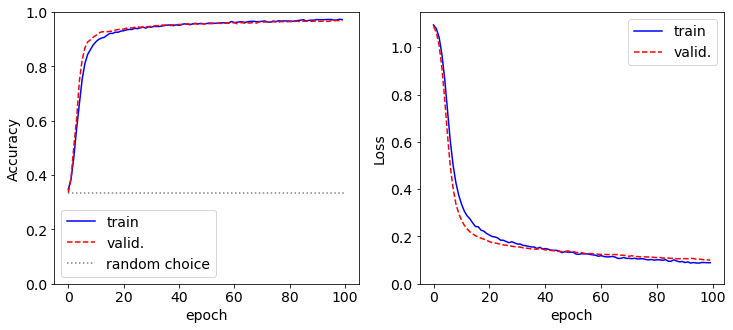

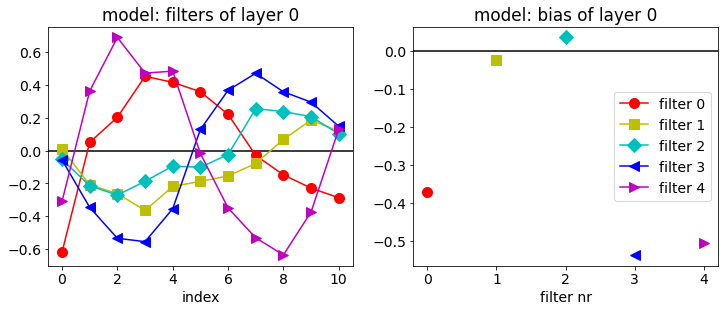

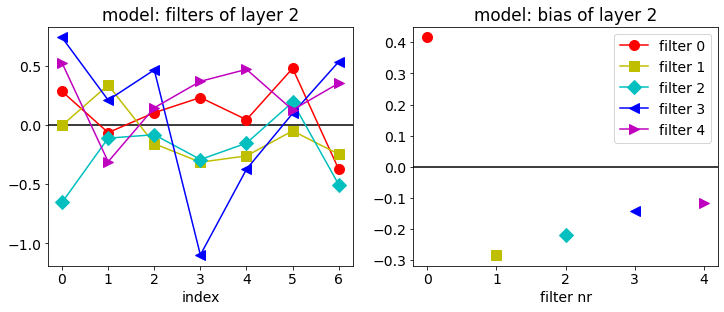

done for: 1e-05


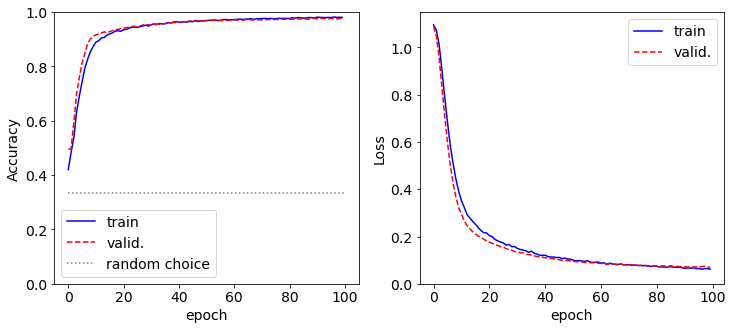

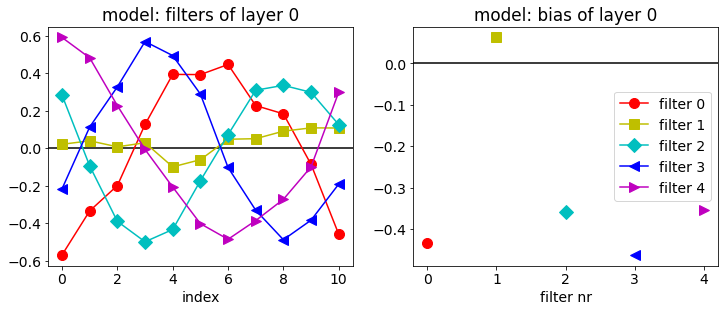

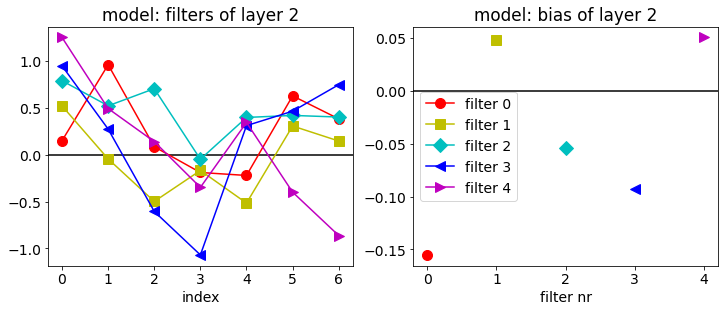

done for: 1e-06


In [5]:
lambdas=[0,10**(-1),10**(-2),10**(-3),10**(-4),10**(-5),10**(-6)]
#lambdas=[10**(-3)]
list_train_acc=[]
list_valid_acc=[]
BATCH_SIZE = 250
EPOCHS = 100

for lambdaa in lambdas:
    
    str0 = 'ts_L60_Z12_A500_DX50_bias5_N10000.dat'
    fnamex='DATA/x_'+str0
    fnamey='DATA/y_'+str0

    x = np.loadtxt(fnamex, delimiter=" ",dtype=float)
    N,L = len(x), len(x[0])

   # Show_data(x,L,"original data")

    categ = np.loadtxt(fnamey, dtype=int)
    n_class = 3    # y.argmax() - y.argmin() +1
    #print('data: ',N)

    y = np.zeros((N,n_class))
    for i in range(N):
        y[i][categ[i]] = 1.
        
    xm = x.mean(axis=1)
    for i in range(N):
        x[i] = x[i]-xm[i]


    x = x/400
    
    #Show_data(x,L,"rescaled data")

    perc_train=0.8
    N_train = int(perc_train*N)
    x_train = x[:N_train]
    y_train = y[:N_train]
    x_val = x[N_train:]
    y_val = y[N_train:]
    N_val = len(x_val)
    #print('N_train=',N_train,'  N_val=',N_val,'  L=',L,'  n_class=',n_class)

    x_train = x_train.reshape(x_train.shape[0], L, 1)
    x_val =  x_val.reshape(x_val.shape[0], L, 1)
    input_shape = (L, 1)    
        
    model=CNN(lambdaa,input_shape, n_class, 2)
    fit = model.fit(x_train,y_train,batch_size=BATCH_SIZE,
                epochs=EPOCHS,
                validation_data=(x_val, y_val),
                verbose=0, shuffle=True)
    Show_history(fit)
    Show_weights(model,0)
    Show_weights(model,2)
    list_train_acc.append(fit.history['accuracy'][-1])
    list_valid_acc.append(fit.history['val_accuracy'][-1])
    print("done for:",lambdaa)
    

 

In [6]:
TYPE=1
def filename(s,TYPE=1):
    return "./DATA/"+s+"-for-DNN-"+str(TYPE)+".dat"
print("Trainacc_l2",list_train_acc)
print("Validacc_l2",list_valid_acc)
np.savetxt(filename("Trainacc_l2",TYPE),list_train_acc)
np.savetxt(filename("Validacc_l2",TYPE),list_valid_acc)

Trainacc_l2 [0.9632499814033508, 0.9702500104904175, 0.9645000100135803, 0.981374979019165, 0.9822499752044678, 0.971875011920929, 0.9801250100135803]
Validacc_l2 [0.9664999842643738, 0.9739999771118164, 0.9660000205039978, 0.9760000109672546, 0.9750000238418579, 0.9679999947547913, 0.9760000109672546]


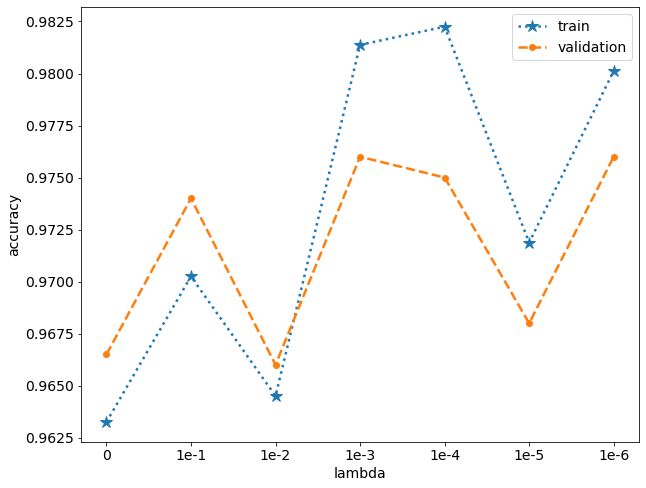

In [7]:

x = np.loadtxt(filename("Trainacc_l2",TYPE), delimiter=' ')
y = np.loadtxt(filename("Validacc_l2",TYPE), delimiter=' ')
lambdaa=[0,10**(-1),10**(-2),10**(-3),10**(-4),10**(-5),10**(-6)]

m=[0,1,2,3,4,5,6]
lambdaa1=['0','1e-1','1e-2','1e-3','1e-4','1e-5','1e-6']

fig, ax = plt.subplots(figsize = (10,8))
ax.plot(m, x, label = 'train', linestyle = 'dotted', marker = '*', markersize = 12,linewidth ='2.5')
ax.plot(m, y, label = 'validation',linestyle = 'dashed', marker = '.',markersize = 12, linewidth ='2.5')
ax.set_xlabel('lambda')
ax.set_ylabel('accuracy')
#plt.xticks(m,size=10)
ax.set_xticks(m)

ax.set_xticklabels(lambdaa1)

plt.legend(loc = 'best')
plt.savefig('plot_lambda_l2.png')